In [1]:
import numpy as np, sys, json, datetime, multiprocessing
import matplotlib.pyplot as plt
import tikzplotlib as tkz
from tqdm.auto import tqdm

from envs import IndependentPricingEnv
from agents import PricingAgentIndep
from utils import generate_curves, generate_user_ranges

In [2]:
def trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, algs, trial_id):
    
    demands = generate_curves(num_products, num_actions=num_actions)
    
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])

    env = IndependentPricingEnv(num_products, num_actions, np.repeat(actions.reshape(1, -1), num_products, axis=0), 
                                demands, user_ranges, seed=trial_id)
    optimal_actions, optimal_values = env.compute_optimal_actions()
    
    indep_instances = []
    results_dict = {key : {"res" : np.zeros((horizon, num_products)), "act" : np.zeros((horizon, num_products), dtype=int)} 
                    for key in algs}
    
    for i in range(num_products): 
        indep_instances.append(PricingAgentIndep(L_kernel, 1/(2*np.sqrt(user_ranges[i, 0])), 1, horizon, actions))
    
    for t in tqdm(range(horizon)):
        
        for i in range(num_products):
            results_dict[indep]["act"][t, i] = indep_instances[i].pull()
        
        res = env.step(results_dict[indep]["act"][t, :])
        
        for i in range(num_products):
            indep_instances[i].update(res[i, 0] / res[i, 1])
            results_dict[indep]["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 0] * actions[results_dict[indep]["act"][t, i]]

    return results_dict

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

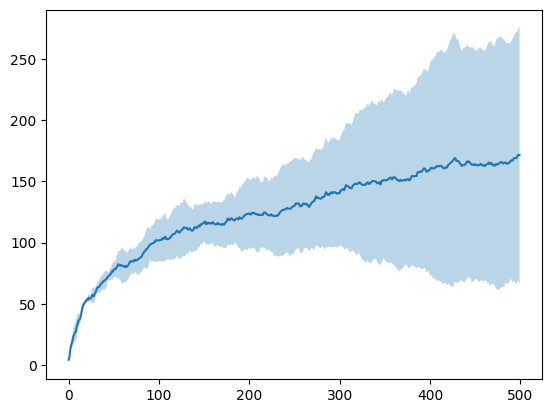

In [3]:
num_actions = 10
num_products = 2
horizon = 500
user_ranges_overall = [10, 30]
actions = np.linspace(0.1, 1.0, num_actions)
L_kernel = 1
num_trials = 3

indep = "Indep"
joint = "Joint"
algs = [indep]

results_dict = []
for i in range(num_trials):
    results_dict.append(trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, algs, i))

plt.figure()

x_plt = np.linspace(0, horizon-1, horizon, dtype=int)

for alg in algs:

    aux = np.zeros((num_trials, horizon))
    
    for i in range(num_trials):
        aux[i, :] = np.array(results_dict[i][alg]["res"]).sum(axis=1)
        
    results_alg = np.cumsum(aux, axis=1)
    results_mean = np.mean(results_alg, axis=0)
    results_std = 1.96 * results_alg.std(axis=0) / np.sqrt(num_trials)

    plt.plot(x_plt, results_mean[x_plt], label=alg)
    plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)